# **About the Notebook:**
### **Softmax Regression with in ERM Framework.**

This notebook contains all the code presented in the slides. Please run the code as we progress


## Understanding Data:

Dataset Used = iris.csv

In [3]:
# Necessary Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [6]:
df = pd.read_excel("Iris.csv.xlsx") # changed to read_csv and the correct file name
# Step 2: Dataset Information
print("Dataset Preview:")
print(df.head())  # Show first 5 rows
print("\nDataset Information:")
print(df.info())  # Summary of dataset

Dataset Preview:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
mem

In [7]:
# Step 3: Extract features (X) and target labels (y)
X = df.iloc[:, 1:-1].values  # All columns except the first and the last one (features) since the first column is an index
y = df.iloc[:, -1].values   # Last column (target)

# Step 4: Convert categorical labels to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to integers (0,1,2)

# Step 5: One-Hot Encode the Labels
one_hot_encoder = OneHotEncoder(sparse_output=False) #changed sparse to sparse_output and set to False
y_one_hot = one_hot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Display results
print("\nUnique Classes:", np.unique(y))
print("Encoded Labels:", np.unique(y_encoded))
print("One-Hot Encoded Labels:\n", y_one_hot[:5])  # Show first 5


Unique Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Encoded Labels: [0 1 2]
One-Hot Encoded Labels:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [8]:
# Step 6: Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot)

# Output shapes
print("\nShapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (120, 4) y_train: (120, 3)
X_test: (30, 4) y_test: (30, 3)


## Decision Function or Model.

In [9]:
import numpy as np

def softmax(z):
    """
    Compute the softmax probabilities for a given input matrix.

    Parameters:
    z (numpy.ndarray): Logits (raw scores) of shape (m, n), where
                       - m is the number of samples.
                       - n is the number of classes.

    Returns:
    numpy.ndarray: Softmax probability matrix of shape (m, n), where
                   each row sums to 1 and represents the probability
                   distribution over classes.

    Notes:
    - The input to softmax is typically computed as: z = XW + b.
    - Uses numerical stabilization by subtracting the max value per row.
    """

    # Prevent numerical instability by normalizing input
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


## Implement Loss and Cost Function:

## Loss Function:

In [10]:
import numpy as np

def loss_softmax(y_pred, y):
    """
    Compute the cross-entropy loss.

    Parameters:
    y_pred (numpy.ndarray): Predicted probabilities of shape (n, c), where n is the number of samples and c is the number of classes.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).

    Returns:
    float: Cross-entropy loss.
    """
    epsilon = 1e-12  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Prevent log(0) by clipping values
    n = y.shape[0]  # Number of samples
    loss = -np.sum(y * np.log(y_pred)) / n
    return loss


## Cost Function:

In [11]:
def cost_softmax(X, y, W, b):
    """
    Compute the softmax regression cost (cross-entropy loss).

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c), where c is the number of classes.
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    float: The softmax cost (cross-entropy loss).
    """
    n = X.shape[0]  # Number of samples
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    cost = loss_softmax(y_pred, y)
    return cost

## Implement Optimization with Gradient Descent:

### Compute the Gradients:

In [12]:
def compute_gradient_softmax(X, y, W, b):
    """
    Compute the gradients of the cost function with respect to weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    tuple: Gradients with respect to weights (d, c) and biases (c,).
    """
    n, d = X.shape
    z = np.dot(X, W) + b
    y_pred = softmax(z)

    grad_W = np.dot(X.T, (y_pred - y)) / n  # Gradient with respect to weights
    grad_b = np.sum(y_pred - y, axis=0) / n  # Gradient with respect to biases

    return grad_W, grad_b


### Perform Gradient Descent:

In [13]:
def gradient_descent_softmax(X, y, W, b, alpha, n_iter, show_cost=False):
    """
    Perform gradient descent to optimize the weights and biases.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d).
    y (numpy.ndarray): True labels (one-hot encoded) of shape (n, c).
    W (numpy.ndarray): Weight matrix of shape (d, c).
    b (numpy.ndarray): Bias vector of shape (c,).
    alpha (float): Learning rate.
    n_iter (int): Number of iterations.
    show_cost (bool): Whether to display the cost at intervals.

    Returns:
    tuple: Optimized weights, biases, and cost history.
    """
    cost_history = []

    for i in range(n_iter):
        # Compute gradients
        grad_W, grad_b = compute_gradient_softmax(X, y, W, b)

        # Update weights and biases using the gradients
        W -= alpha * grad_W
        b -= alpha * grad_b

        # Compute and store cost
        cost = cost_softmax(X, y, W, b)
        cost_history.append(cost)

        # Print cost at regular intervals
        if show_cost and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i}: Cost = {cost:.6f}")

    return W, b, cost_history


## Prediction Function:

In [14]:
def predict_softmax(X, W, b):
    """
    Predict the class labels for a set of samples using the trained softmax model.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    W (numpy.ndarray): Weight matrix of shape (d, c), where c is the number of classes.
    b (numpy.ndarray): Bias vector of shape (c,).

    Returns:
    numpy.ndarray: Predicted class labels of shape (n,), where each value is the index of the predicted class.
    """
    z = np.dot(X, W) + b  # Compute the scores (logits)
    y_pred = softmax(z)  # Get the probabilities using the softmax function

    # Assign the class with the highest probability
    predicted_classes = np.argmax(y_pred, axis=1)

    return predicted_classes

Iteration 0: Cost = 1.020958
Iteration 100: Cost = 0.473181
Iteration 200: Cost = 0.265637
Iteration 300: Cost = 0.222653
Iteration 400: Cost = 0.195284
Iteration 500: Cost = 0.176145
Iteration 600: Cost = 0.161964
Iteration 700: Cost = 0.151008
Iteration 800: Cost = 0.142271
Iteration 900: Cost = 0.135127
Iteration 999: Cost = 0.129223


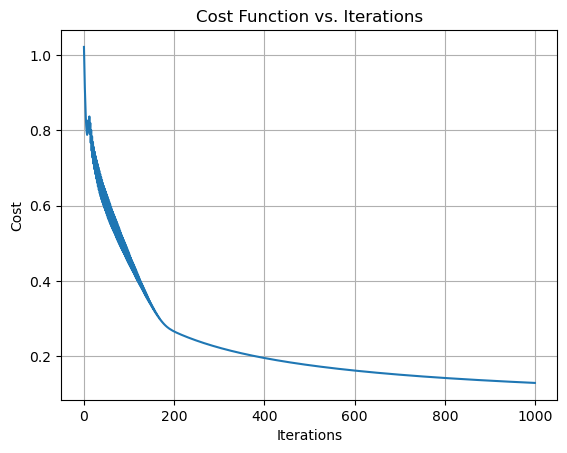

In [15]:
# Initialize the weights and biases
d = X_train.shape[1]  # Number of features
c = y_train.shape[1]  # Number of classes
W = np.random.randn(d, c) * 0.01  # Small random weights
b = np.zeros(c)  # Bias initialized to 0

# Set hyperparameters
alpha = 0.1  # Learning rate
n_iter = 1000  # Number of iterations

# Train the model using gradient descent
W_opt, b_opt, cost_history = gradient_descent_softmax(X_train, y_train, W, b, alpha, n_iter, show_cost=True)

# Plot the cost history to visualize the convergence
plt.plot(cost_history)
plt.title('Cost Function vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

# Predict on the test set
#y_pred_test = predict_softmax(X_test, W_opt, b_opt)

# Evaluate accuracy
#y_test_labels = np.argmax(y_test, axis=1)  # True labels in numeric form
#accuracy = np.mean(y_pred_test == y_test_labels)
#print(f"Test accuracy: {accuracy * 100:.2f}%")

## Evaluting the Model.


Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Precision: 0.97
Recall: 0.97
F1-Score: 0.97


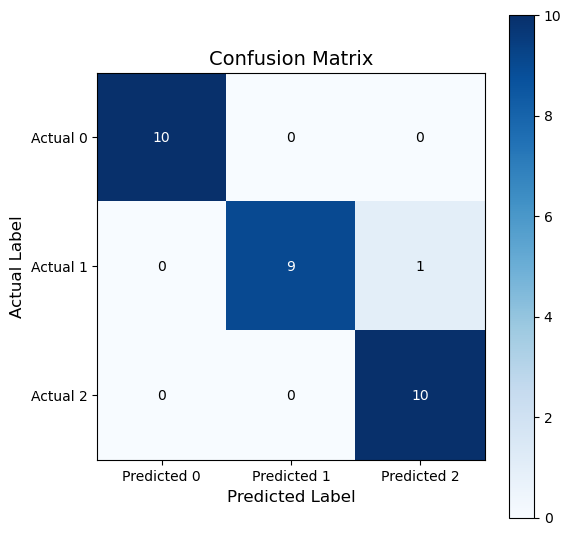

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Evaluation Function
def evaluate_classification(y_true, y_pred):
    """
    Evaluate classification performance using confusion matrix, precision, recall, and F1-score.

    Parameters:
    y_true (numpy.ndarray): True labels
    y_pred (numpy.ndarray): Predicted labels

    Returns:
    tuple: Confusion matrix, precision, recall, F1 score
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return cm, precision, recall, f1

# Predict on the test set
y_pred_test = predict_softmax(X_test, W_opt, b_opt)
# Evaluate accuracy
y_test_labels = np.argmax(y_test, axis=1)  # True labels in numeric form

# Evaluate the model
cm, precision, recall, f1 = evaluate_classification(y_test_labels, y_pred_test)

# Print the evaluation metrics
print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Visualizing the Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.imshow(cm, cmap='Blues')  # Use a color map for better visualization

# Set tick labels for the axes
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels([f'Predicted {i}' for i in range(3)])
ax.set_yticklabels([f'Actual {i}' for i in range(3)])

# Add labels to each cell in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > np.max(cm) / 2 else 'black')

# Add grid lines and axis labels
ax.grid(False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.colorbar(cax)
plt.show()


# **Limitations of Logistic Regression:**

C:\Users\ACER\AppData\Local\Temp\ipykernel_7196\3018090940.py:33: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', marker='x', label='Test')


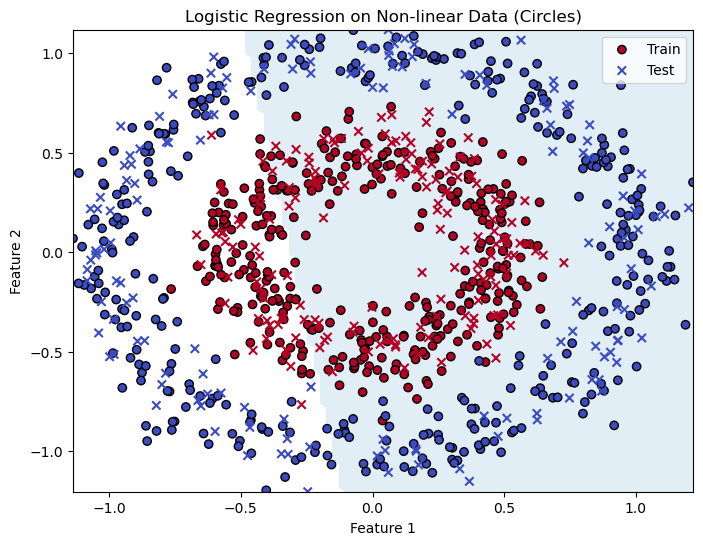

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Step 1: Generate a synthetic non-linear dataset using make_circles
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 4: Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

# Step 5: Predict on the meshgrid points to plot the decision boundary
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 6: Plot the data points and the decision boundary
plt.figure(figsize=(8, 6))

# Plot the decision boundary
plt.contourf(xx, yy, Z, levels=[0, 0.5], cmap='Blues', alpha=0.2)

# Plot the training data points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', marker='x', label='Test')

plt.title("Logistic Regression on Non-linear Data (Circles)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
